In [209]:
import os
import urllib2
import netCDF4
import numpy as np
import json
import logging
import matplotlib.pyplot as plt
import matplotlib
import folium
import seawater
import cf
netCDF4.__version__
%matplotlib inline

In [211]:
matplotlib.rcParams.update({'font.size': 16})

# Functions

##  To get and read the data

In [100]:
def create_opendap_list(platformlist):
    opendaplist = []    
    for deployments in platformlist[0]['jsonInstrumentList'][0]['jsonDeploymentList']:
        logging.debug(deployments['productsByProcessingLevel']['L1'][0])
        opendaplist.append(deployments['productsByProcessingLevel']['L1'][0])
    return opendaplist

In [281]:
def create_opendap_list_profilers(platformlist):
    opendaplist = []
    for pp in platformlist2:
        opendaplist.append(pp['jsonInstrumentList'][0]['jsonDeploymentList'][0]['productsByProcessingLevel']['L1'][0])
    return opendaplist

In [282]:
def get_CTD_positions(datafile):
    with netCDF4.Dataset(datafile) as nc:
        lonvariable = nc.get_variables_by_attributes(standard_name='longitude')[0].name
        latvariable = nc.get_variables_by_attributes(standard_name='latitude')[0].name
        lon = nc.variables[lonvariable][:]
        lat = nc.variables[latvariable][:]
        cruiseinstitute = nc.institution.split('(')[0]
        cruisestart = nc.time_coverage_start.split('T')[0]
        cruiseend = nc.time_coverage_end.split('T')[0]
    return lon, lat, cruiseinstitute, cruisestart, cruiseend

## To create the T-S diagrams

In [217]:
def make_TS_plot(psal, temp, figtitle, figname):
    figure = plt.figure(figsize=(10, 10))
    plt.plot(psal, temp, 'k.', ms=0.5)
    
    # Compute density for T-S couples
    # to add lines on the T-S diagram
    density2plot = np.arange(24, 30, .5)
    smin, smax, tmin, tmax = 37.0, 38.75, 12., 28.
    ds, dt = 0.05, 0.1
    tvec = np.arange(tmin,tmax, dt)
    svec = np.arange(smin,smax, ds)
    ssvec, ttvec = np.meshgrid(svec, tvec)
    density = seawater.eos80.dens0(ssvec,ttvec) - 1000.0
    cont = plt.contour(svec, tvec, density, levels=density2plot, colors='.65', linestyles='dashed')
    plt.clabel(cont,inline=True, fmt='%1.1f')
    plt.xlim(smin, smax)
    plt.ylim(tmin, tmax)
    plt.xlabel('Salinity', fontsize=20)    
    plt.ylabel('Temperature\n($^{\circ}$C)', fontsize=20, rotation=0, ha='right')
    plt.title(figtitle)
    plt.savefig(figname)
    plt.close()

# Loop on the files

In [298]:
logger = logging.getLogger()
logger.setLevel(logging.ERROR)
create_map = True
makeTS = False

ERROR:root:Cannot read the file (maybe private)
ERROR:root:Cannot read the file (maybe private)
ERROR:root:Cannot read the file (maybe private)
ERROR:root:Cannot read the file (maybe private)
ERROR:root:Cannot read the file (maybe private)


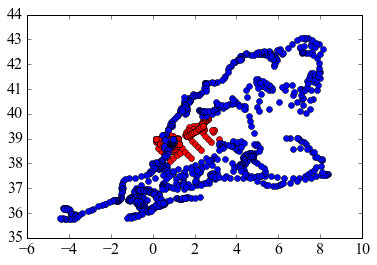

In [299]:
logging.info('Data discovery for CTD')
response = urllib2.urlopen('http://apps.socib.es/DataDiscovery/list-platforms?instrument_type=CTD')
platformlist = json.loads(response.read())
opendaplist = create_opendap_list(platformlist)
for files in opendaplist:
    #logging.debug("Working on file {0}".format(files))
    try:
        lon, lat, cruiseinstitute, cruisestart, cruiseend = get_CTD_positions(files)
        plt.plot(lon, lat, 'ro')
    except IOError:
        logger.error("Cannot read the file (maybe private)")

logging.info('Data discovery for Profilers')
response = urllib2.urlopen('http://apps.socib.es/DataDiscovery/list-platforms?instrument_type=Profiler%20drifter')
platformlist2 = json.loads(response.read())
opendaplist2 = create_opendap_list_profilers(platformlist2)

for files in opendaplist2:
    #logging.debug("Working on file {0}".format(files))
    try:
        lon, lat, cruiseinstitute, cruisestart, cruiseend = get_CTD_positions(files)
        plt.plot(lon, lat, 'bo')
    except IOError:
        logger.error("Cannot read the file (maybe private)")

# Create a leaflet map to explore the dataset

In [300]:
outputdir = '/home/ctroupin/public_html/LeafletMaps/'
mapCTD = folium.Map(location=[39.5, 2], zoom_start=8)


npoints = 0

for files in opendaplist:
    logging.debug("Working on file {0}".format(files))
    files = files.replace('thredds.socib', 'thredds.priv.socib')
    try:
    
        lon, lat, cruiseinstitute, cruisestart, cruiseend = get_CTD_positions(files)
        figtitle = "Start: {0}, end: {1}".format(cruisestart, cruiseend)
        if create_map:
            html = "Start: {0}<br /> end: {1}<br/> Institute: {2}".format(cruisestart, cruiseend, cruiseinstitute)
            iframe = folium.element.IFrame(html=html, width=200, height=100)
        
            year = cruisestart[:4]
            vesselurl = "http://socib.es/users/ctroupin/LeafletMaps/vessel_{0}.png".format(year)

            npoints = npoints + len(lon)
            for llon, llat in zip(lon, lat):
                iconVessel = folium.features.CustomIcon(vesselurl, icon_size=(20, 20))
                popup = folium.Popup(iframe, max_width=200)
                folium.Marker([llat, llon], icon=iconVessel, popup=popup).add_to(mapCTD)
        
        if makeTS:
            # Create the T-S diagram
            f = cf.read(files)
            tempCTD = 0.5*(f.select('sea_water_temperature')[0].array + 
                           f.select('sea_water_temperature')[1].array)
            psalCTD = 0.5*(f.select('sea_water_practical_salinity')[0].array + 
                           f.select('sea_water_practical_salinity')[1].array)
            f.close()

            figname = files.split('/')[-1].split('.')[0]
            figname = os.path.join(outputdir, figname)
            make_TS_plot(psalCTD, tempCTD, figtitle, figname)
            
    except IOError:
        logger.error("Cannot read the file (maybe private)")
        
for files in opendaplist2:
    
    logging.debug("Working on file {0}".format(files))
    try:
        lon, lat, cruiseinstitute, cruisestart, cruiseend = get_CTD_positions(files)
        figtitle = "Start: {0}, end: {1}".format(cruisestart, cruiseend)
        
        if create_map:
            html = "Start: {0}<br /> end: {1}<br/> Institute: {2}".format(cruisestart, cruiseend, cruiseinstitute)
            iframe = folium.element.IFrame(html=html, width=200, height=100)
        
            year = cruisestart[:4]
            profilerurl = "http://socib.es/users/ctroupin/LeafletMaps/profiler_drifter.png"

            npoints = npoints + len(lon)
            for llon, llat in zip(lon.compressed(), lat.compressed()):
                iconProfiler = folium.features.CustomIcon(profilerurl, icon_size=(20, 20))
                popup = folium.Popup(iframe, max_width=200)
                folium.Marker([llat, llon], icon=iconProfiler, popup=popup).add_to(mapCTD)
        
        if makeTS:
            # Create the T-S diagram
            f = cf.read(files)
            tempCTD = 0.5*(f.select('sea_water_temperature')[0].array + 
                           f.select('sea_water_temperature')[1].array)
            psalCTD = 0.5*(f.select('sea_water_practical_salinity')[0].array + 
                           f.select('sea_water_practical_salinity')[1].array)
            f.close()

            figname = files.split('/')[-1].split('.')[0]
            figname = os.path.join(outputdir, figname)
            make_TS_plot(psalCTD, tempCTD, figtitle, figname)
        
        
    except IOError:
        logger.error("Cannot read the file (maybe private)")
        
logger.info("Plotting {0} points".format(npoints))

2.359
2.542
2.839
3.084
3.364
3.514
3.666
3.776
3.932
3.93
4.068
4.312
4.412
4.385
4.497
4.448
4.581
5.053
5.116
5.043
4.944
4.915
4.982
5.16
5.244
5.39
5.561
5.679
5.689
5.627
5.545
5.426
5.271
5.142
5.015
5.158
5.089
4.978
5.097
5.533
6.049
6.588
7.057
7.347
7.51
7.647
7.841
7.915
7.991
7.979
7.924
7.8
7.727
7.787
7.708
7.351
7.067
7.137
7.521
7.562
7.096
6.713
6.888
7.176
7.191
7.089
6.768
6.321
6.184
6.374
6.646
7.021
7.184
7.284
7.379
7.442
7.472
7.512
7.574
7.674
7.775
7.883
7.929
7.942
7.922
7.837
7.621
7.58
7.943
8.142
7.977
7.669
7.481
7.319
7.181
7.137
7.115
7.13
7.132
7.075
7.057
7.05
7.218
7.552
7.746
7.782
7.634
7.411
7.245
7.255
7.308
7.227
7.078
6.874
6.677
6.441
6.083
5.93
6.17
6.227
6.053
5.832
5.779
5.81
5.794
5.829
5.942
5.905
5.804
5.657
5.57
5.614
5.666
5.687
5.445
5.49
5.55
5.558
5.617
5.765
5.673
5.399
5.323
5.238
5.198
5.153
5.287
5.328
5.168
5.085
5.033
5.038
4.942
4.85
4.677
4.517
4.441
4.386
4.262
4.227
4.188
4.147
4.095
4.023
4.094
4.199
4.2
4.194
4.15
3.938

AttributeError: 'numpy.ndarray' object has no attribute 'compressed'

In [301]:
mapname = "CTDmap.html"
mapCTD.save(os.path.join(outputdir, mapname))

In [295]:
lat.compressed()

array([ 39.927,  39.923,  40.003,  40.06 ,  40.233,  40.332,  40.38 ,
        40.415,  40.534,  40.421,  40.397,  40.295,  40.202,  40.329,
        40.687,  40.976,  41.12 ,  41.29 ,  41.341,  41.402,  41.402,
        41.29 ,  41.195,  41.122,  41.138,  41.057,  40.963,  40.967,
        41.038,  41.113,  41.164,  41.261,  41.333,  41.259,  41.051,
        40.79 ,  40.524,  40.29 ,  40.108,  40.189,  40.458,  40.346,
        40.098,  40.019,  40.187,  40.593,  40.963,  41.178,  41.446,
        41.696,  41.734,  41.519,  41.291,  41.305,  41.384,  41.32 ,
        41.008,  40.585,  40.542,  40.975,  40.995,  40.763,  40.464,
        40.37 ,  40.619,  40.74 ,  40.872,  40.978,  41.071,  41.176,
        41.157,  40.992,  40.935,  40.971,  41.067,  41.235,  41.428,
        41.579,  41.658,  41.664,  41.577,  41.542,  41.656,  41.834,
        42.041,  42.245,  42.477,  42.798,  42.809,  42.615,  42.419,
        42.38 ,  42.456,  42.439,  42.472,  42.446,  42.488,  42.496,
        42.548,  42.